# Prepare Fashion Kaggle dataset for training NanoGPT

Tokenizes and saves the [fashion kaggle dataset](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset) in binary format suitable for training NanoGPT.

## 0 - Prerequisites



This notebook is standalone, it does not use NanoGPT repository. All necessary installs are detailed in this section.

First some pip install and imports.

In [4]:
import os
import tarfile

import psutil
import requests
import PIL
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate as custom_collate
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython.display

Clone [Open-MAGVIT2](https://github.com/TencentARC/Open-MAGVIT2.git), download the tokenizer model [imagenet_256_B](https://huggingface.co/TencentARC/Open-MAGVIT2/resolve/main/imagenet_256_B.ckpt) and import lfqgan module to be able to load the model. We will use this model as an image tokenizer.


```bash
cd /content
git clone https://github.com/TencentARC/Open-MAGVIT2.git
```

```bash
mkdir model
cd model
wget https://huggingface.co/TencentARC/Open-MAGVIT2/resolve/main/imagenet_256_B.ckpt
```


In [5]:
%%capture
!pip install lightning einops omegaconf

In [6]:
import sys
import importlib

from omegaconf import OmegaConf
from einops import rearrange


sys.path.append('/content/Open-MAGVIT2')
lfqgan = importlib.import_module('taming.models.lfqgan', package='/content/Open-MAGVIT2')

Clone [taming-transformer](https://github.com/CompVis/taming-transformers.git) repo and import CustomTest. We are only using CustomTest dataset class that allows you to create a torch dataset from a list of files.

```
cd /content
git clone https://github.com/CompVis/taming-transformers.git
```

In [7]:
import sys
import importlib

sys.path.append('/content/taming-transformers')

custom = importlib.import_module('taming.data.custom', package='/content/taming-transformers')


## 1 - Download [Fashion Product Image Dataset](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset)




The dataset contains 44K 256*256 colored images of fashion items.
![kaggle_fashion.png](kaggle_fashion.png)

In [8]:
def download_and_extract_dataset():
        url = 'https://github.com/rom1504/kaggle-fashion-dalle/releases/download/1.0.0/fashion_kaggle.tar'
        root_dir = "/content"
        target_dir = os.path.join(root_dir, 'fashion_kaggle')
        if not os.path.exists(target_dir):
            os.makedirs(target_dir)

        dataset_tar = os.path.join(target_dir, 'fashion_kaggle.tar')
        response = requests.get(url, stream=True)
        with open(dataset_tar, 'wb') as f:
            for chunk in tqdm(response.iter_content(chunk_size=1024)):
                if chunk:
                    f.write(chunk)

        with tarfile.open(dataset_tar, 'r') as tar:
            tar.extractall(target_dir)

In [9]:
download_and_extract_dataset()

645160it [01:06, 9646.31it/s] 


Take a look at one image

/content/fashion_kaggle/fashion_kaggle/4243.jpg


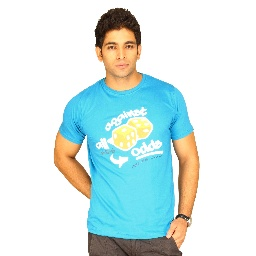

In [10]:
dataset_dir = "/content/fashion_kaggle/fashion_kaggle"
images = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith(".jpg")]

for img in images:
  print(img)
  break

IPython.display.Image(filename=img)

## 2 - Create the Dataloader


First, create the torch dataset.

In [11]:
def write_img_file_list(in_directory, out_file):
  '''
  list all the *.jpg files in in_directory and write all paths to out_file
  '''
  img_paths = [os.path.abspath(os.path.join(in_directory, f))
    for f in os.listdir(in_directory)
    if f.endswith(".jpg")]
  with open(out_file, 'w') as f:
    for path in img_paths:
      f.write(path + "\n")

write_img_file_list("/content/fashion_kaggle/fashion_kaggle", "/content/fashion_kaggle/images_list.txt")
kaggle_dataset = custom.CustomTest(size=256, test_images_list_file="/content/fashion_kaggle/images_list.txt")

Split train/validation set.

In [12]:
g_cpu = torch.Generator()
g_cpu.manual_seed(1234)

train, val = torch.utils.data.random_split(kaggle_dataset, [0.9, 0.1], generator=g_cpu)

print(f"Length of train set: {len(train)} ({100*len(train)/(len(train)+len(val)):0.0f}%)")
print(f"Length of validation set: {len(val)} ({100*len(val)/(len(train)+len(val)):0.0f}%)")

Length of train set: 39997 (90%)
Length of validation set: 4444 (10%)


Create the dataloader and check first item.

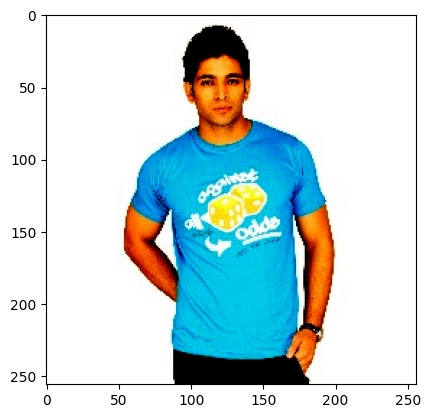

In [27]:
dataloader = DataLoader(kaggle_dataset,
                        batch_size=10,
                        num_workers=1,
                        collate_fn=custom_collate,
                        shuffle=False,
                        pin_memory=True)

for batch in dataloader:
  break

image = batch['image'][0].cpu().numpy()
plt.imshow(image)
plt.show()

## 3 - Load the tokenizer model and try it out



In [28]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def load_vqgan_new(config, ckpt_path=None, is_gumbel=False):
  model = lfqgan.VQModel(**config.model.init_args)
  if ckpt_path is not None:
    sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
  return model.eval()

# load the model
config_file = "/content/Open-MAGVIT2/configs/imagenet_lfqgan_256_B.yaml"
configs = OmegaConf.load(config_file)
ckpt_path = "/content/model/imagenet_256_B.ckpt"
model = load_vqgan_new(configs, ckpt_path).to(DEVICE)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/content/Open-MAGVIT2/taming/modules/losses/lpips.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [35]:
# utils

def custom_to_pil(x):
  '''
  convert a pytorch tensor to a PIL image
  '''
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = PIL.Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def plot_side_by_side(original, reconstructed):
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))

  axes[0].imshow(original)
  axes[0].set_title("Original")
  axes[0].axis('off')
  title1 = "Original"

  axes[1].imshow(reconstructed)
  axes[1].set_title("Reconstructed")
  axes[1].axis('off')
  title2 = "Reconstructed"

  plt.show()

Encode images with the tokenizer

In [20]:
def encode_batch(batch):
  '''
  encode a batch of images
  input: batch of N images (N, H, W, C)
  output:
    - quant: tensor of quantized images. Shape is (N, embed_dim, 16, 16)
    - tokens: tensor of token ids. Shape is (N * 16 * 16)
  N: batch size
  C: the number of channels (e.g., 3 for an RGB image)
  H: height
  W: width
  embed_dim: the embedding dimension of the tokenizer model
  '''
  # reordering tensors and saving to device
  images = batch["image"].permute(0, 3, 1, 2).to(DEVICE)

  # encode
  with torch.no_grad():
    quant, emb_loss, tokens, loss_breakdown = model.encode(images)

  return quant, tokens

quant, tokens = encode_batch(batch)

Decode from quantized images (i.e. embeddings). Quantized image tensors are of shape (N, embed_dim, 16, 16)

INPUT (a batch of quantized images):
 tensor([[[[ 1., -1., -1.,  ..., -1.,  1., -1.],
          [-1.,  1., -1.,  ..., -1.,  1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ...,  1., -1., -1.],
          [ 1., -1., -1.,  ...,  1.,  1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[ 1., -1.,  1.,  ..., -1., -1., -1.],
          [ 1.,  1., -1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1., -1.,  1.],
          ...,
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1., -1.,  1.,  ...,  1., -1.,  1.],
          [-1.,  1., -1.,  ...,  1., -1., -1.]],

         ...,

         [[ 1.,  1., -1.,  ..., 

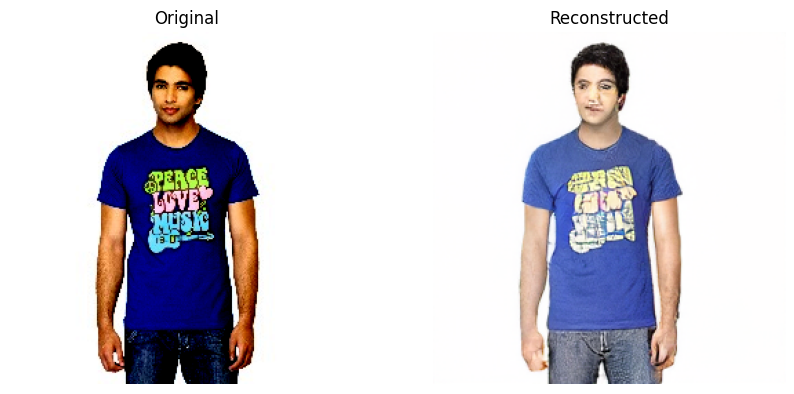

In [40]:
def decode_quant(quant):
  '''
  decode a batch of quantized images
  input: quantized images (N, embed_dim, 16, 16). Tensor values are {+1, -1}
  output: reconstructed images (N, C, H, W)
  '''
  # decode
  with torch.no_grad():
    reconstructed_images = model.decode(quant)
  return reconstructed_images

print(f"INPUT (a batch of quantized images):\n {quant}")
reconstructed_images = decode_quant(quant)
# all batch is reconstructed, i.e N images. Choose an index from 0..N-1
k = 5
reconstructed = custom_to_pil(reconstructed_images[k])

# plot images original vs reconstructed
original = batch['image'][k].cpu().numpy()
plot_side_by_side(original, reconstructed)

Alternatively you can decode from token indices. Tokens indices are of shape (N * 16 * 16).

INPUT:
 tensor([192188,  23094,  56849,  ...,  22549,  52132,  25750], device='cuda:0')
OUTPUT:



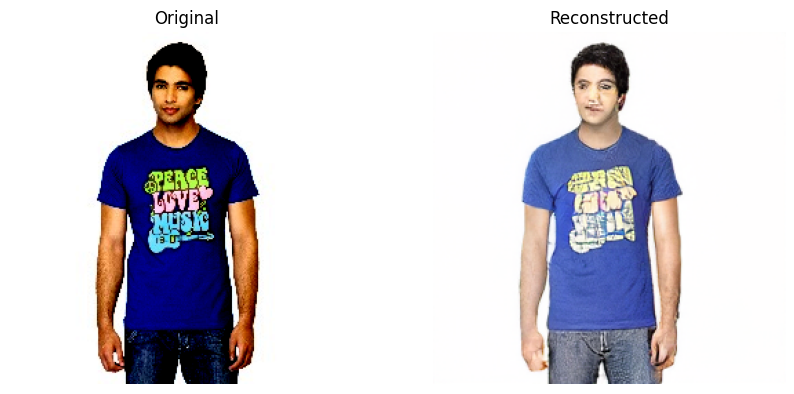

In [39]:
def decode_from_indices(tokens):
  '''
  decode a batch of token ids
  input: token ids (N * 16 * 16)
  output: reconstructed images (N, C, H, W)
  '''
  # from token ids to embeddings
  x = rearrange(tokens, "(b s) -> b s", b=10)
  quant = model.quantize.get_codebook_entry(x, (10, 16, 16, 18))

  # decode
  return decode_quant(quant)


print(f"Input (batch of token ids):\n {tokens}")
reconstructed_images = decode_from_indices(tokens)
# all batch is reconstructed, i.e N images. Choose an index from 0..N-1
k = 5
reconstructed = custom_to_pil(reconstructed_images[5])


# plot images original vs reconstructed
original = batch['image'][k].cpu().numpy()
plot_side_by_side(original, reconstructed)

## 4 - Create the train and val binary files

Takes a few minutes on GPU (L4, 22GB RAM)

In [ ]:
#utils

# Function to print memory usage
def print_memory_usage(stage):
    print(f"[{stage}] CPU memory usage:")
    process = psutil.Process()
    mem_info = process.memory_info()
    print(f"RSS: {mem_info.rss / (1024 ** 2):.2f} MB, VMS: {mem_info.vms / (1024 ** 2):.2f} MB")

    if torch.cuda.is_available():
        print(f"[{stage}] GPU memory usage:")
        print(f"Allocated: {torch.cuda.memory_allocated() / (1024 ** 2):.2f} MB")
        print(f"Reserved: {torch.cuda.memory_reserved() / (1024 ** 2):.2f} MB")

In [46]:
BATCH_SIZE = 64
NUM_WORKERS = 8

# Write a binary file
print_memory_usage("start")

model = load_vqgan_new(configs, ckpt_path).to(DEVICE)
# print_memory_usage("after loading model")

for split in ["val", "train"]:
  if split == "train":
    dataset = train
    filename = '/content/train.bin'
    total = train.__len__()
  else:
    dataset = val
    filename = '/content/val.bin'
    total = val.__len__()

  dtype = np.uint16
  arr_len = len(dataset)*16*16
  arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
  # print_memory_usage("after creating memmap")

  dataloader = DataLoader(dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        collate_fn=custom_collate,
                        shuffle=False,
                        pin_memory=True)

  array_list = []
  with torch.no_grad():
      for idx, batch in tqdm(enumerate(dataloader), total=total//BATCH_SIZE):
          # print_memory_usage(f"before processing batch {idx}")

          images = batch["image"].permute(0, 3, 1, 2).to(DEVICE)
          # print_memory_usage(f"after moving images to DEVICE for batch {idx}")

          if model.use_ema:
              with model.ema_scope():
                  quant, _, tokens, _ = model.encode(images)
          else:
              quant, _, tokens, _ = model.encode(images)

          array_list.append(tokens.cpu().numpy())
          # print_memory_usage(f"after appending quantized batch {idx}")

  arr[:] = np.concatenate(array_list)
  # print_memory_usage("after concatenating array_list")
  arr.flush()
  # print_memory_usage("after flushing memmap")


[start] CPU memory usage:
RSS: 3670.39 MB, VMS: 28081.88 MB
[start] GPU memory usage:
Allocated: 1949.73 MB
Reserved: 13216.00 MB


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/content/Open-MAGVIT2/taming/modules/losses/lpips.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


70it [01:08,  1.03it/s]
625it [10:06,  1.03it/s]


In [ ]:
# Clean GPU Memory

del model
del arr
del array_list ## this one takes a small bit of ram
del dataloader ## this one takes a lot of ram
del batch
del images
del quant

torch.cuda.empty_cache()

import gc
gc.collect()

7447